# Bilan du 26 Juillet

In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import impaintingLib as imp
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed   = 1
shuffle = seed == 0
if not shuffle : 
    torch.manual_seed(seed)

batch_size = 8
plot = imp.utils.Visu(gridSize=batch_size).plot_img
lowresize = 1
highresize = 4
factorResize = 4

resize = (120*factorResize, 120*factorResize)
crop   = (64*factorResize, 64*factorResize)

process = transforms.Compose([
     transforms.Resize(resize), 
     transforms.CenterCrop(crop),
     transforms.ToTensor()
])

In [2]:
def npToTensor(x):
    c,w,h = x.shape
    x = x / 8
    x = torch.from_numpy(x).to(device)
    x = torch.reshape(x, (c,1,w,h))
    return x

def simplifyChannels(x):
    x = np.where(x == 3, 0, x) 
    x = np.where(x == 4, 3, x) 
    x = np.where(x == 5, 3, x) 
    x = np.where(x == 6, 4, x) 
    x = np.where(x == 7, 4, x) 
    x = np.where(x == 8, 5, x) 
    x = np.where(x == 9, 5, x) 
    x = np.where(x == 10 , 6, x) 
    x = np.where(x == 11, 7, x) 
    x = np.where(x == 12, 7, x)  
    x = np.where(x > 12, 0, x) 
    return x

### Old 
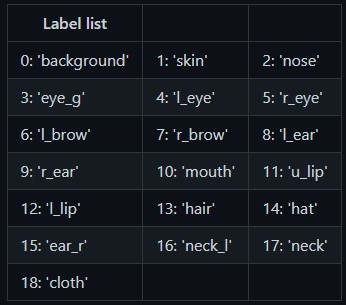

### Now 
- 1 : skin
- 2 : nose
- 3 : eye
- 4 : brow 
- 5 : ear
- 6 : mouth
- 7 : lip

tensor([[0.2039, 0.2235, 0.2745,  ..., 0.1294, 0.1137, 0.1216],
        [0.2235, 0.2471, 0.3020,  ..., 0.1451, 0.1529, 0.1373],
        [0.2235, 0.2627, 0.3255,  ..., 0.1647, 0.1804, 0.1412],
        ...,
        [0.1804, 0.1765, 0.1765,  ..., 0.6627, 0.6824, 0.6902],
        [0.1804, 0.1765, 0.1765,  ..., 0.6588, 0.6863, 0.6941],
        [0.1882, 0.1843, 0.1882,  ..., 0.6510, 0.6745, 0.6863]],
       device='cuda:0')


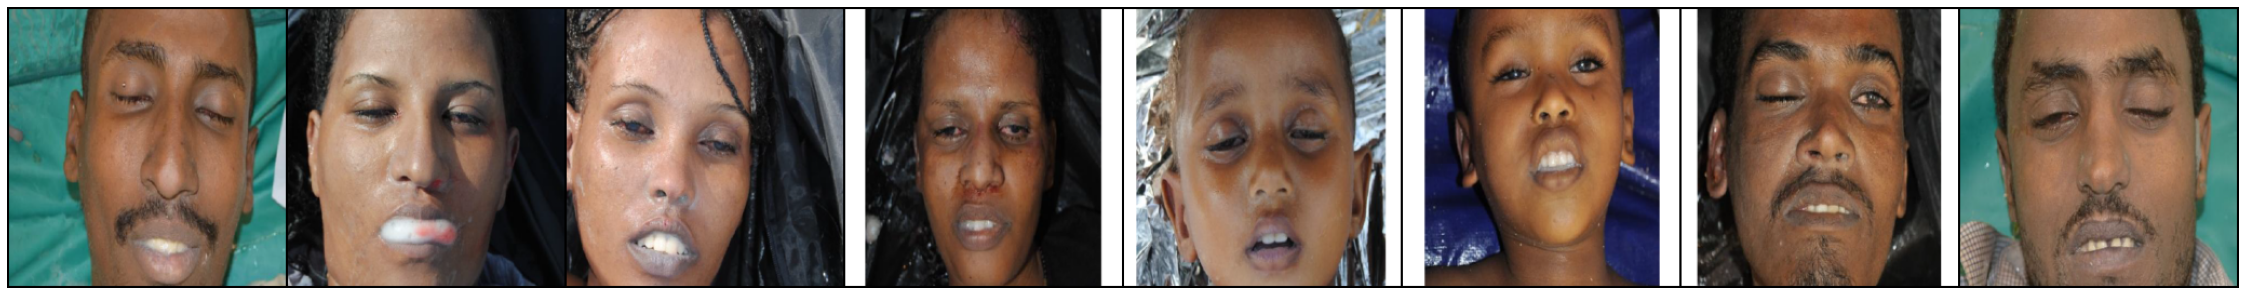

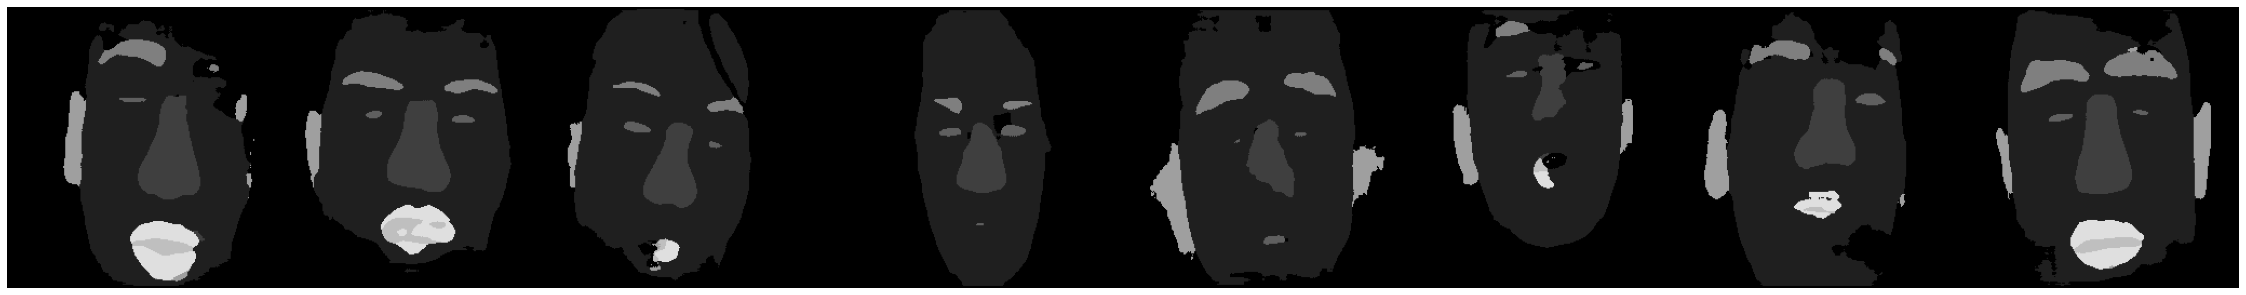

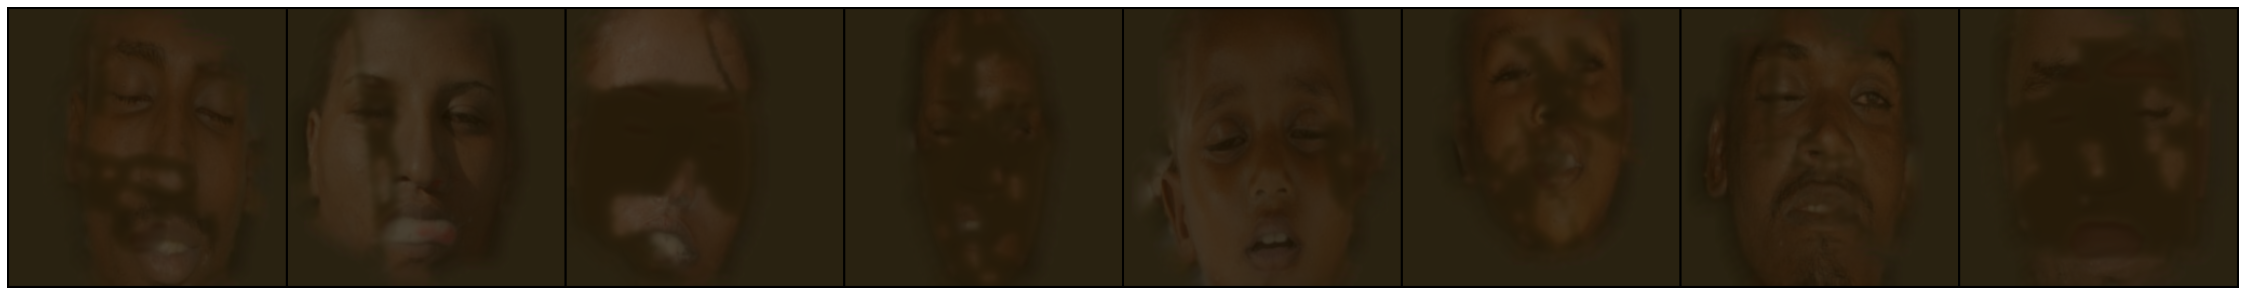

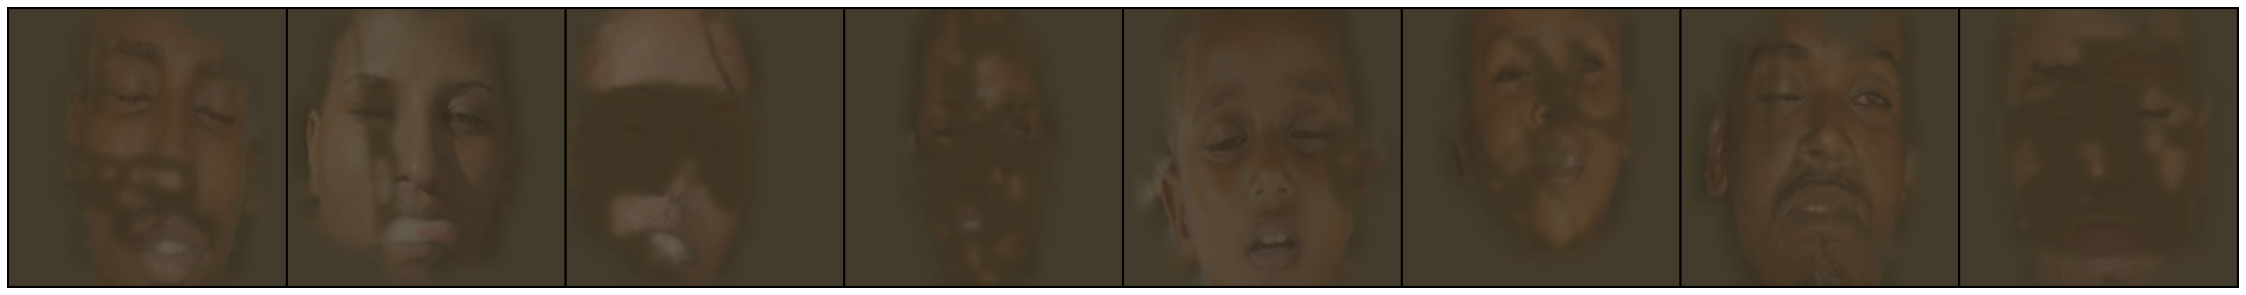

In [25]:
dataset = ImageFolder("./data/real", process)
data = DataLoader(dataset, num_workers=2, batch_size=batch_size, shuffle=shuffle)

img,_ = next(iter(data))
x = img.to(device)
n,c,w,h = x.shape

# Alter
alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask
x_prime = alter(imp.data.normalize(x))

# Add Classifier
classif = imp.loss.getTrainedModel()
normalized = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
classifiedImage = classif(normalized)
classifDisplay = imp.loss.generate_label(classifiedImage,w).to(device)
classifPlain = imp.loss.generate_label_plain(classifiedImage,w)
classifPlain = simplifyChannels(classifPlain)
classifPlain = npToTensor(classifPlain)
classifPlain = classifPlain.float()
x_prime2 = torch.cat((x_prime,classifPlain),dim=1)

# Predict
model = imp.model.UNet(4, netType="partial").to(device) 
path = './modelSave/classify_4channels_xl'
#if factorResize > 1 : 
#    path += '_highres'
path += '.pth'
model.load_state_dict(torch.load(path))
x_hat = model(x_prime2)

print(x[0][0])

# Display
plot(x)
plot(classifPlain)
#plot(classifiedImage[:,1:2])
#plot(classifDisplay)
#plot(imp.data.inv_normalize(x_prime))
plot(imp.data.inv_normalize(x_hat)-0.4)
plot(imp.data.inv_normalize(x_hat)-0.3)

### Résolution 4, 4 augmenté et 7
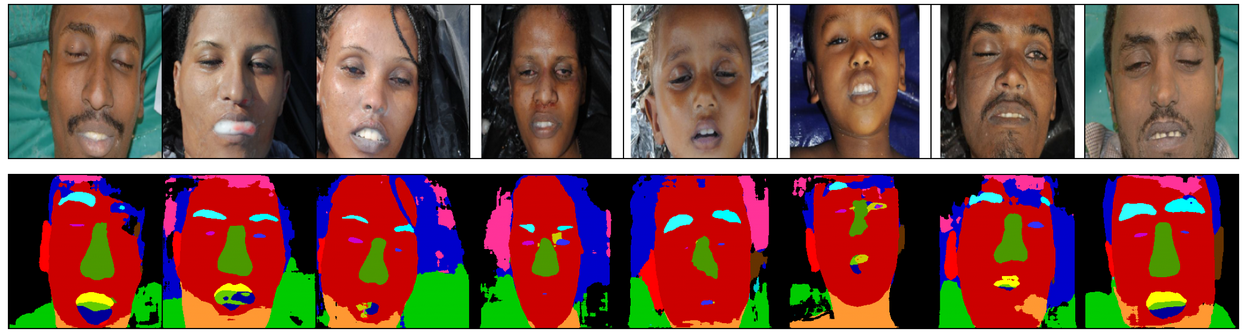
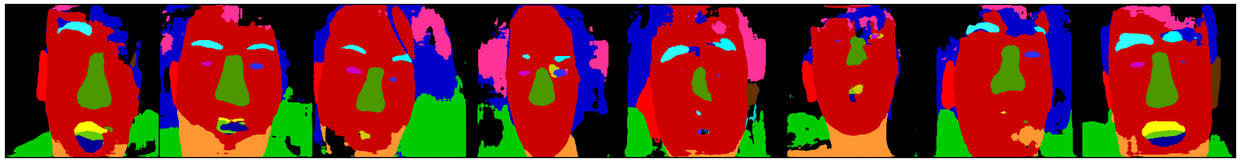
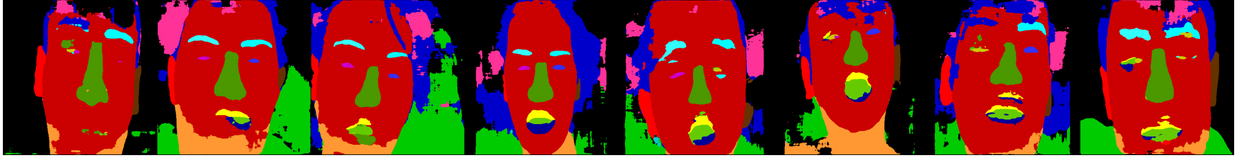

### Résultats si on normalise pas avec norme vgg
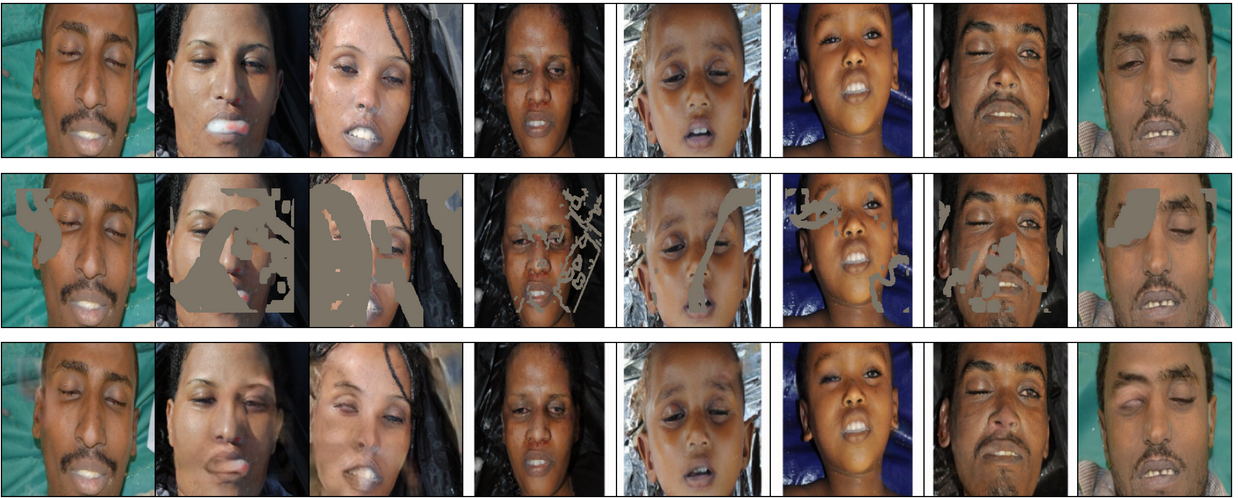
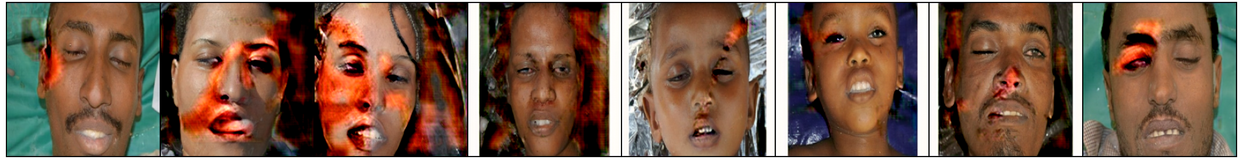

### Uniformisation des masques
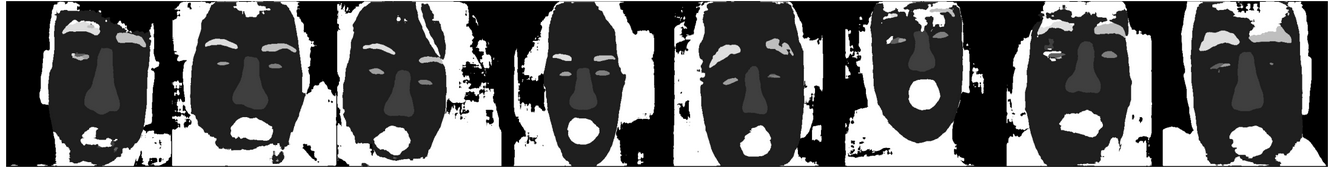
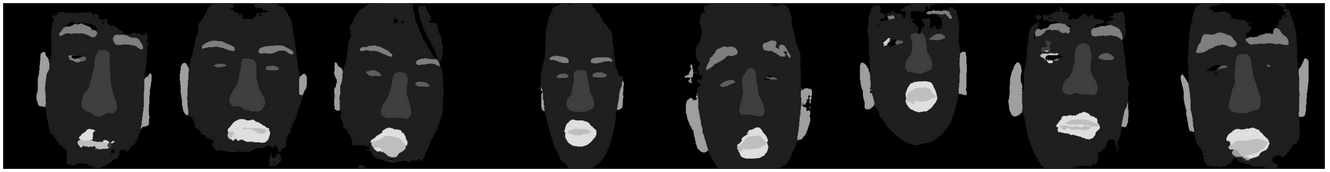